# Data mining \& clustering

The goal if this practical is to adress the folowing problem:
<center style="color:red" >  Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</center>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X =
	\begin{matrix}
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix}
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import collections

import codecs
import re
import os.path
import sklearn
import seaborn as sns


## Data loading



In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [3]:
print(newsgroups_train['data'][0])  # Print the text of the first document
print(newsgroups_train['target'][0])  # Print the label of the first document


From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





7


In [4]:
print(len(newsgroups_train['data']))

11314


In [5]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
44.164928407283014


In [6]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(452, 'haven'), (424, 'gm'), (213, 'children'), (987, 'world'), (439, 'group'), (463, 'higher'), (693, 'play'), (390, 'final'), (161, 'bit'), (201, 'cb')]


In [7]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10])
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

In [8]:
!pip install wordcloud

### Let's look at the most frequent words in this dataset

In [9]:
data = np.array(newsgroups_train.data)
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nb mots=",len(words))
# Lets find the most frequence words Your code here

Nb mots= 3252437


In [12]:
punct = r"[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~\n\t]"
corpus_punc = re.sub(punct, " ", corpus)
corpus_punc = re.sub('( )+', ' ', corpus_punc).lower()

In [21]:
words = corpus_punc.split()
words_counter = collections.Counter(words)
words_counter



Counter({'from': 22673,
         'lerxst': 4,
         'wam': 81,
         'umd': 295,
         'edu': 21321,
         'where': 2716,
         's': 22575,
         'my': 9738,
         'thing': 1532,
         'subject': 12265,
         'what': 9865,
         'car': 1312,
         'is': 43510,
         'this': 20123,
         'nntp': 4814,
         'posting': 5507,
         'host': 4996,
         'rac3': 7,
         'organization': 11233,
         'university': 5589,
         'of': 69049,
         'maryland': 127,
         'college': 628,
         'park': 226,
         'lines': 11835,
         '15': 1807,
         'i': 53128,
         'was': 13661,
         'wondering': 306,
         'if': 13646,
         'anyone': 2468,
         'out': 6217,
         'there': 9690,
         'could': 3511,
         'enlighten': 27,
         'me': 6828,
         'on': 20500,
         'saw': 550,
         'the': 146691,
         'other': 5189,
         'day': 1474,
         'it': 33638,
         'a': 6429

In [23]:
most_frequent_words = words_counter.most_common(100)
most_frequent_words

[('the', 146691),
 ('to', 75073),
 ('of', 69049),
 ('a', 64298),
 ('ax', 62412),
 ('and', 57964),
 ('i', 53128),
 ('in', 49414),
 ('is', 43510),
 ('that', 39273),
 ('it', 33638),
 ('for', 28606),
 ('you', 26692),
 ('from', 22673),
 ('s', 22575),
 ('edu', 21321),
 ('on', 20500),
 ('this', 20123),
 ('be', 19287),
 ('t', 18822),
 ('are', 18629),
 ('not', 18547),
 ('have', 18076),
 ('with', 17333),
 ('as', 15834),
 ('1', 15322),
 ('or', 14689),
 ('was', 13661),
 ('if', 13646),
 ('but', 13429),
 ('they', 13216),
 ('m', 13058),
 ('subject', 12265),
 ('com', 12134),
 ('lines', 11835),
 ('can', 11360),
 ('at', 11332),
 ('organization', 11233),
 ('by', 11170),
 ('re', 10533),
 ('2', 10414),
 ('an', 10110),
 ('what', 9865),
 ('my', 9738),
 ('there', 9690),
 ('3', 9638),
 ('x', 9605),
 ('0', 9536),
 ('all', 9326),
 ('will', 9291),
 ('we', 9232),
 ('one', 9017),
 ('would', 8910),
 ('do', 8686),
 ('he', 8445),
 ('about', 8336),
 ('writes', 7844),
 ('so', 7765),
 ('your', 7644),
 ('no', 7611),
 ('ha

### Plot the N frequent words and verify that its follows a Zipf law

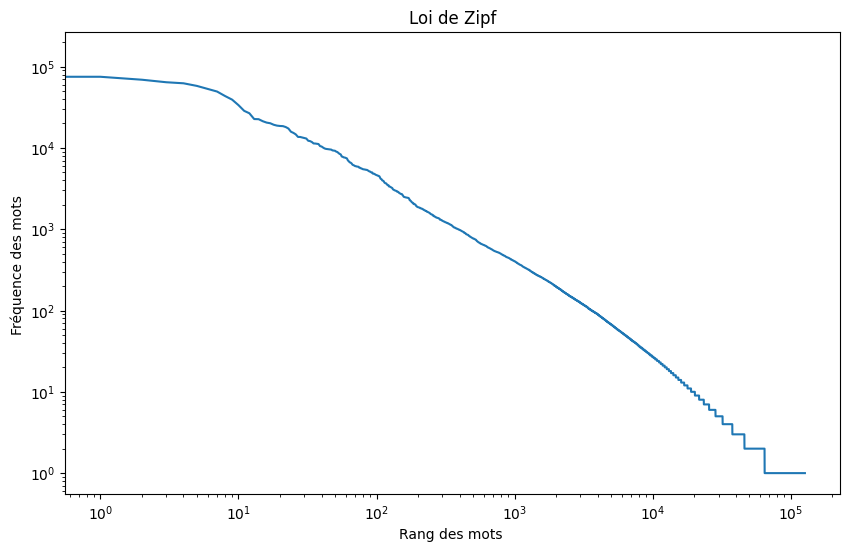

In [35]:
sorted_word_counter = sorted(words_counter.items(), key=lambda x: x[1], reverse=True)

# Extraire les mots et leurs fréquences triés
sorted_words = [item[0] for item in sorted_word_counter]

# Tracer la courbe Zipf
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange( len(sorted_frequencies)), y = sorted_frequencies)
plt.xlabel('Rang des mots ')
plt.ylabel('Fréquence des mots ')
plt.title('Loi de Zipf')
plt.xscale('log')
plt.yscale('log')
plt.show()

### Experiment word clouds

In [37]:
!pip install wordcloud

(-0.5, 399.5, 199.5, -0.5)

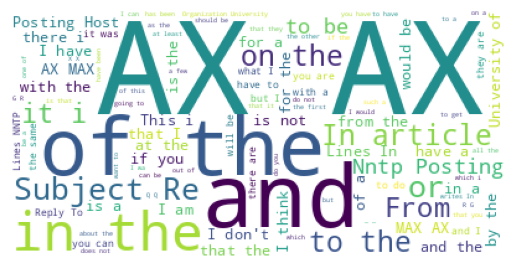

In [42]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus)

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')


(-0.5, 399.5, 199.5, -0.5)

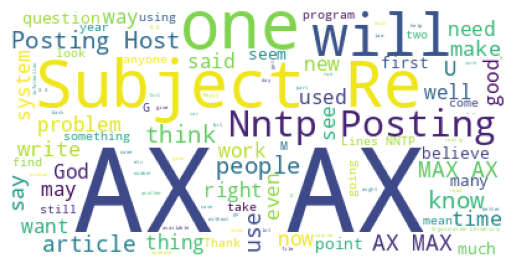

In [43]:
from wordcloud import STOPWORDS # Note: this is the default option
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus)

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies.
N.B.: retrieve the most words frequencies using a CountVectorizer

In [46]:
# Your code here
from sklearn.feature_extraction.text import CountVectorizer

countvect = CountVectorizer()
X = countvect.fit_transform(data)
print(X)

  (0, 56979)	3
  (0, 75358)	2
  (0, 123162)	2
  (0, 118280)	2
  (0, 50527)	2
  (0, 124031)	2
  (0, 85354)	1
  (0, 114688)	1
  (0, 111322)	1
  (0, 123984)	1
  (0, 37780)	5
  (0, 68532)	3
  (0, 114731)	5
  (0, 87620)	1
  (0, 95162)	1
  (0, 64095)	1
  (0, 98949)	1
  (0, 90379)	1
  (0, 118983)	1
  (0, 89362)	3
  (0, 79666)	1
  (0, 40998)	1
  (0, 92081)	1
  (0, 76032)	1
  (0, 4605)	1
  :	:
  (11313, 110796)	2
  (11313, 106209)	1
  (11313, 31386)	1
  (11313, 124103)	1
  (11313, 116027)	1
  (11313, 33941)	1
  (11313, 107339)	1
  (11313, 101950)	1
  (11313, 109661)	1
  (11313, 82480)	1
  (11313, 38329)	2
  (11313, 94524)	1
  (11313, 27696)	1
  (11313, 113435)	1
  (11313, 82355)	1
  (11313, 38325)	1
  (11313, 94291)	1
  (11313, 115621)	1
  (11313, 75884)	1
  (11313, 60910)	2
  (11313, 72419)	1
  (11313, 72881)	1
  (11313, 70020)	1
  (11313, 8653)	1
  (11313, 124370)	1


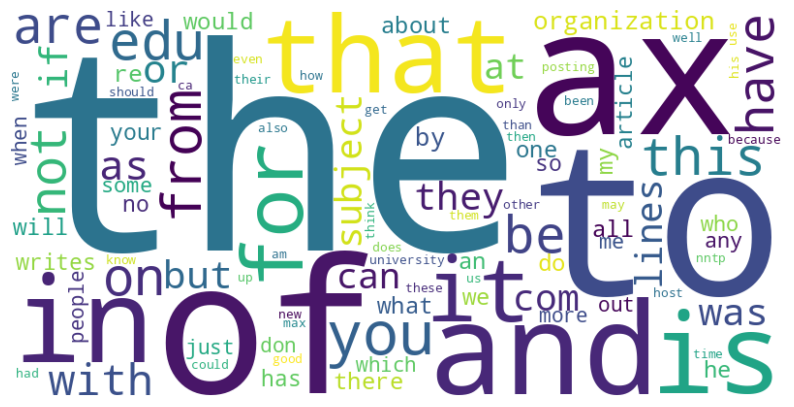

In [52]:

word_freq = dict(zip(countvect.get_feature_names_out(), X.sum(axis=0).A1))
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords = STOPWORDS,
    max_words = 100).generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Drawing word clouds from classes


In [53]:
def word_cloud_from_classes(labels):
    for l in np.unique(labels):
        i = np.where(labels == l)[0]
        corpus_l = ' '.join(data[i])
        corpus_l_ponct = re.sub(punct, " ", corpus_l)
        corpus_l_ponct = re.sub('( )+', ' ', corpus_l_ponct)

        wordcloud = WordCloud(background_color='white',
                              stopwords = STOPWORDS,
                              max_words=100).generate(corpus_l_ponct)

        plt.figure()
        plt.title(l)
        plt.imshow(wordcloud)
        plt.axis("off")

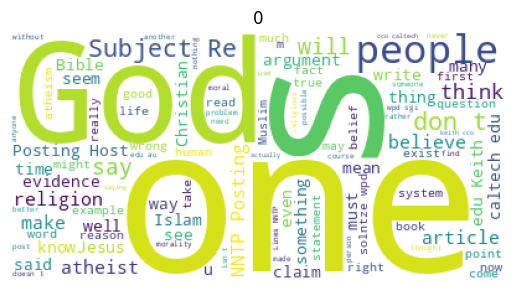

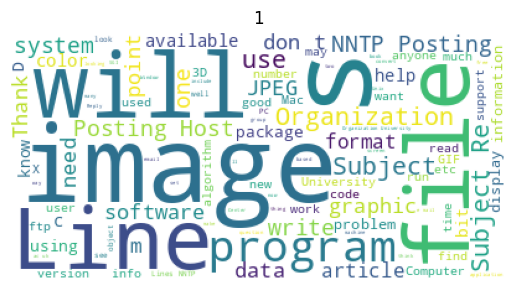

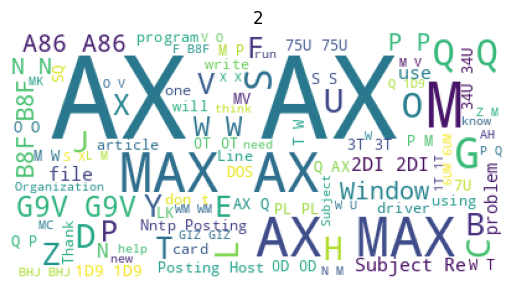

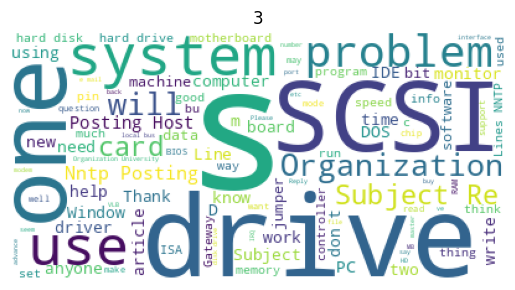

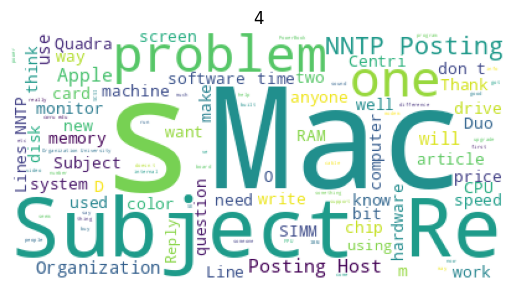

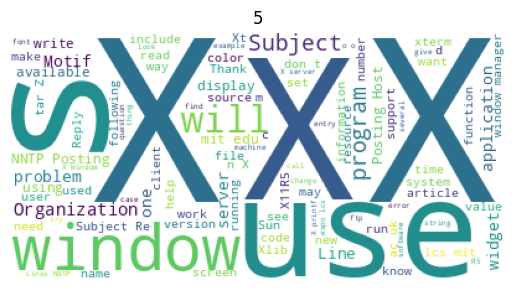

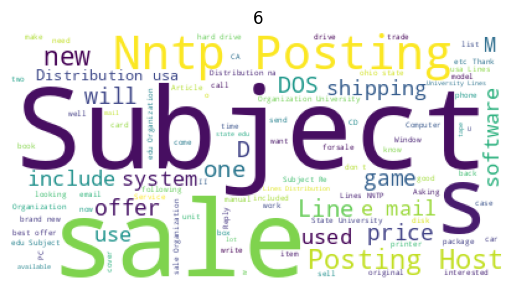

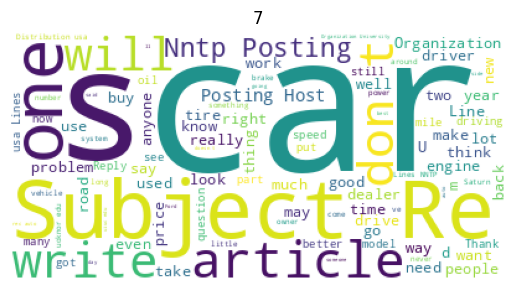

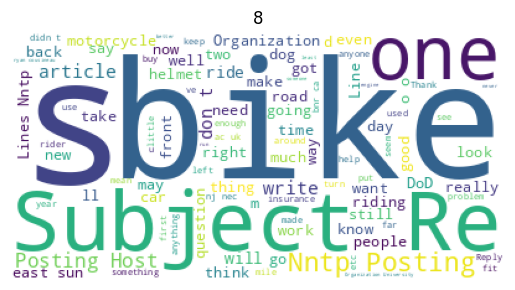

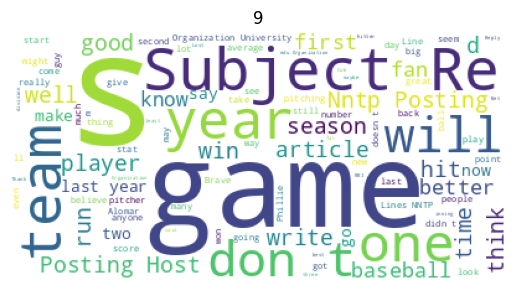

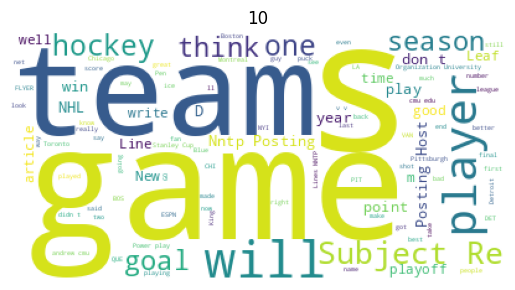

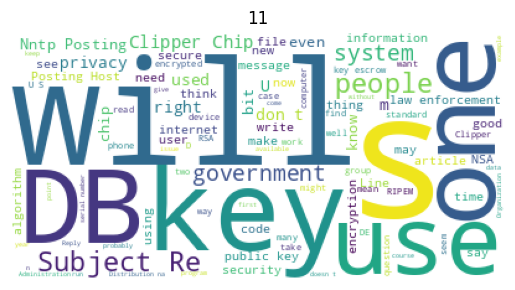

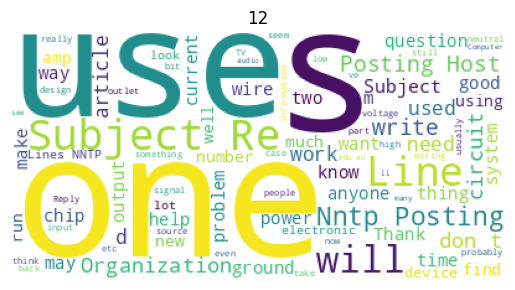

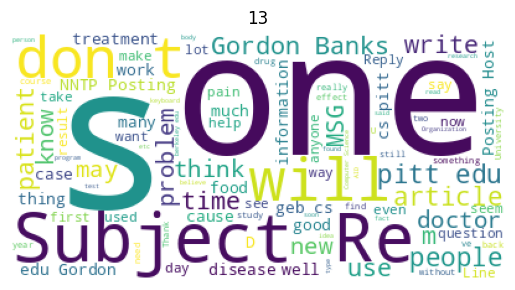

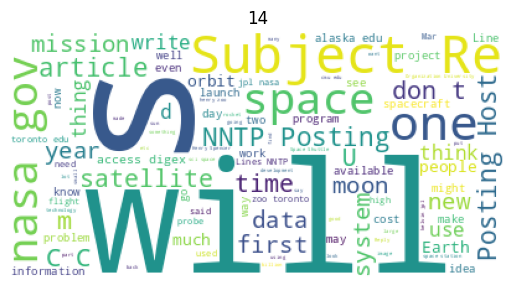

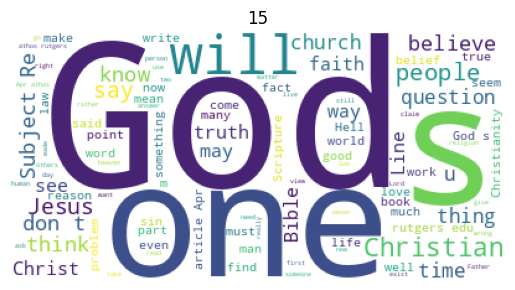

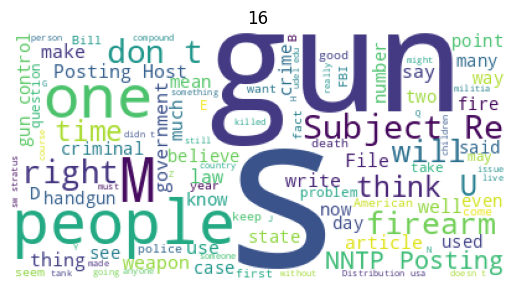

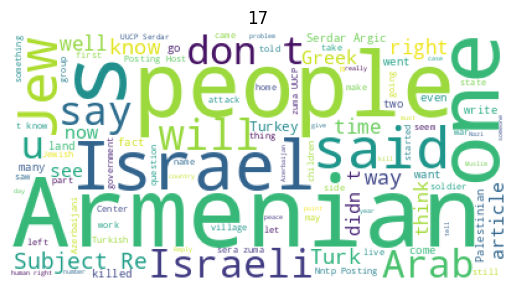

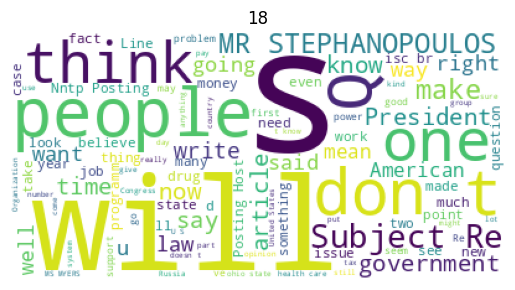

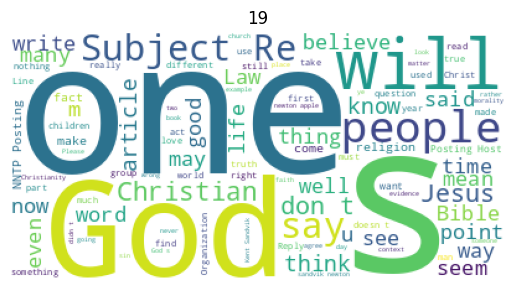

In [54]:
word_cloud_from_classes(Y)

# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [55]:
from sklearn.cluster import KMeans
# your code here
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[0.00481251, 0.00431009, 0.00048919, ..., 0.00481887, 0.01265084,
        0.00097928],
       [0.00369518, 0.01008388, 0.00139004, ..., 0.01172087, 0.00496925,
        0.00488701],
       [0.00390038, 0.00431445, 0.0023992 , ..., 0.00616613, 0.00405261,
        0.00336554],
       ...,
       [0.00050777, 0.00514748, 0.00089056, ..., 0.00369742, 0.00111354,
        0.        ],
       [0.00836867, 0.0035352 , 0.        , ..., 0.00816881, 0.0031431 ,
        0.01436739],
       [0.0015631 , 0.00515836, 0.00593669, ..., 0.00522794, 0.00822491,
        0.00154939]])

In [56]:
vectors.shape, kmeans.cluster_centers_.shape

((11314, 1000), (20, 1000))

### Clustering Analysis:
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
2. **Quantitative:**
    - Compute cluster "purity": $p_j= |y^*_j|$, where $y^*_j$ is the most frequent (GT) label in cluster $C_j$ $\Rightarrow$ $p = \frac{1}{N}\sum\limits_j  p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score)

In [57]:
# Look at the most important words for each cluster
most_important_word_idx = np.abs(kmeans.cluster_centers_).argmax(1)
most_important_word_idx

array([202, 679, 241, 622, 193, 409, 519, 977, 687, 923, 505, 976, 346,
       336, 787, 185, 427, 285, 104, 924])

In [58]:
for cl, i in enumerate(most_important_word_idx):
    print(cl, ':', vectorizer.get_feature_names_out()[i])

0 : cc
1 : people
2 : com
3 : nasa
4 : card
5 : game
6 : key
7 : windows
8 : pitt
9 : uiuc
10 : israel
11 : window
12 : edu
13 : drive
14 : sale
15 : ca
16 : god
17 : cwru
18 : andrew
19 : uk


In [59]:
# Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
Y_pred = kmeans.predict(vectors)
print(Y_pred[:10])
print(np.unique(Y_pred))

[12 12  1  2 12  2 12 13 14  4]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


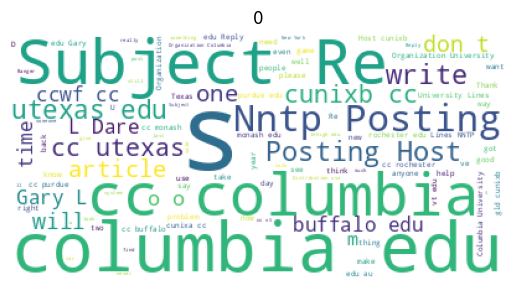

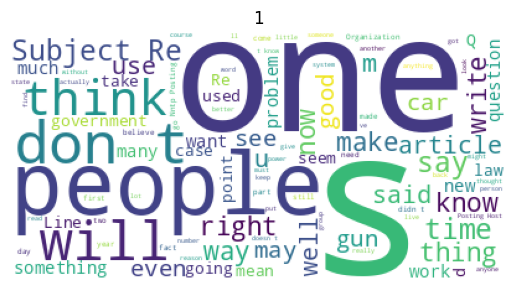

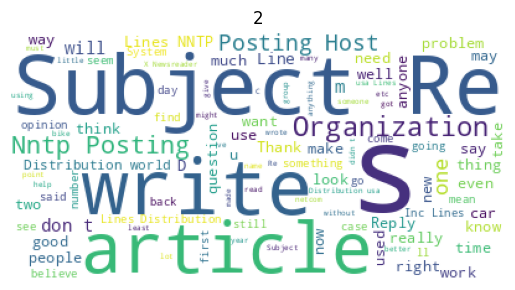

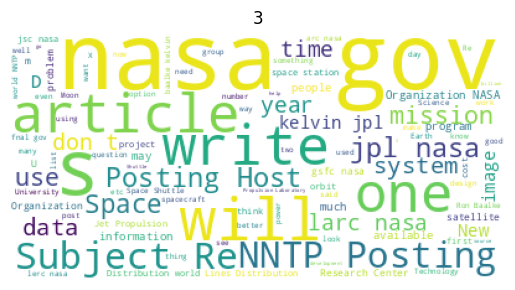

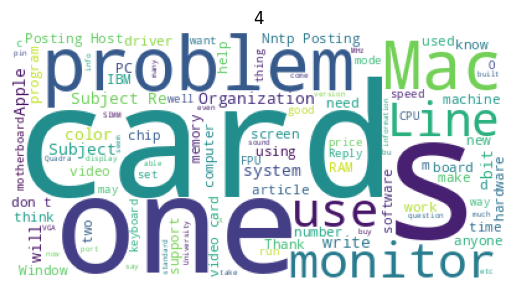

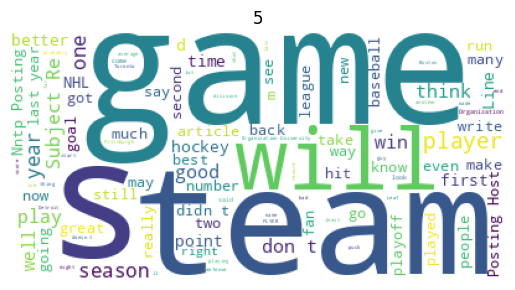

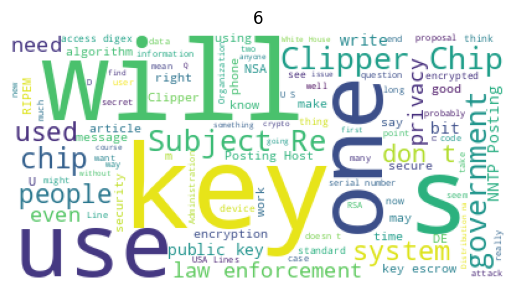

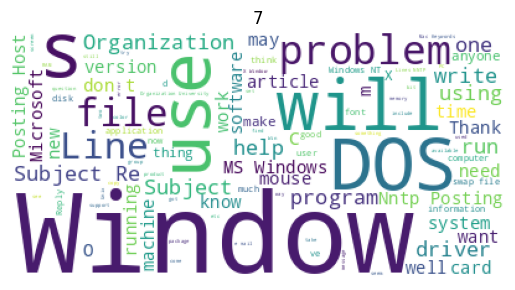

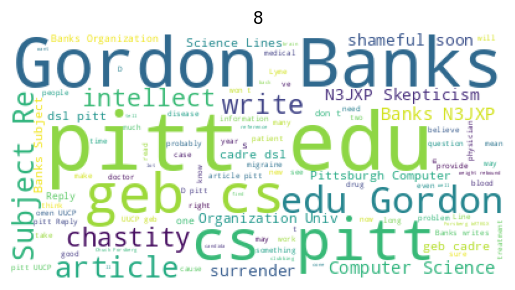

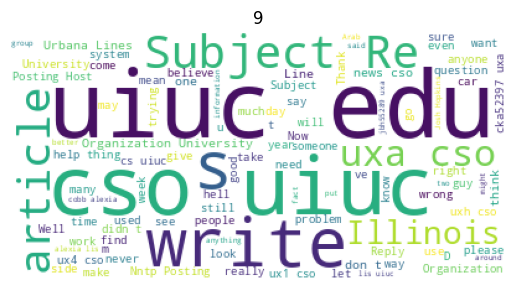

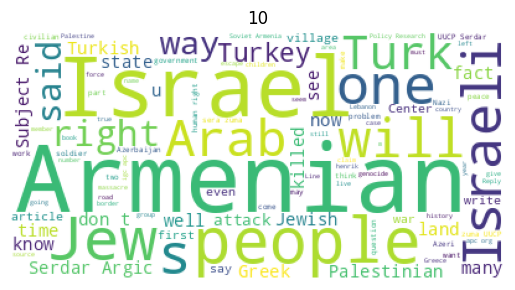

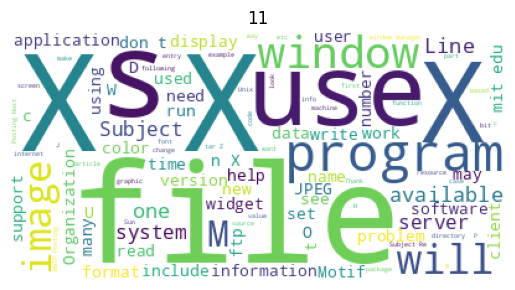

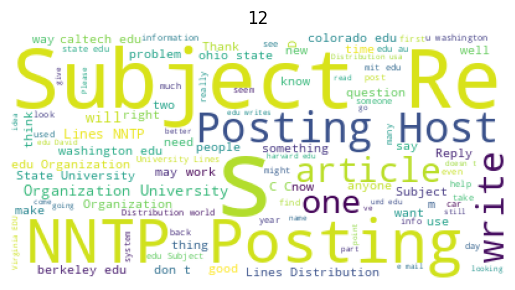

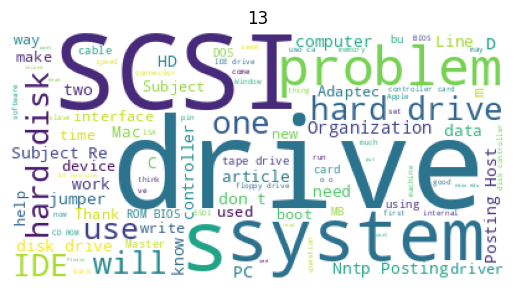

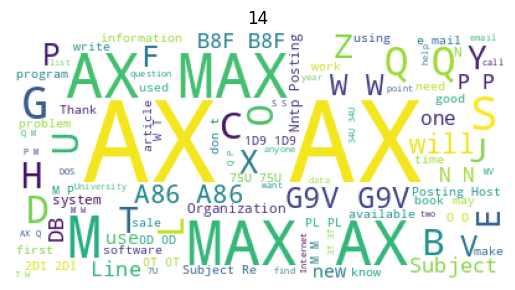

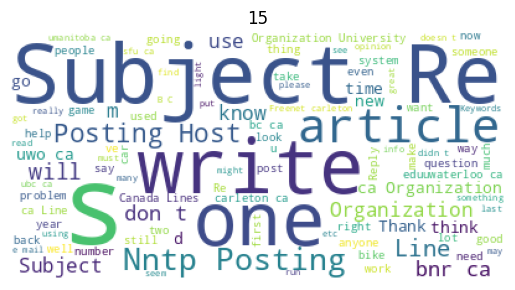

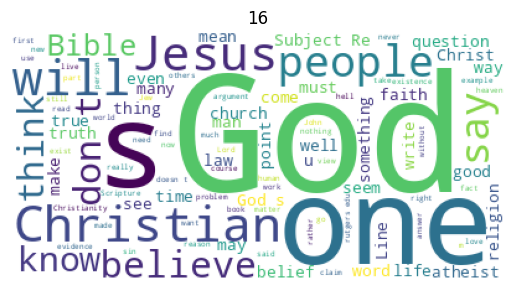

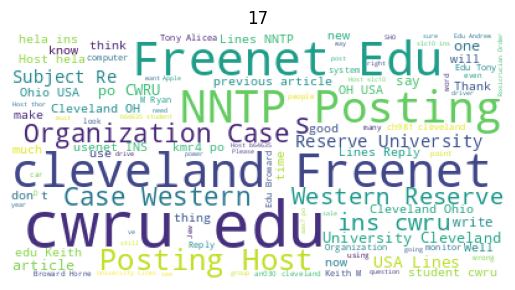

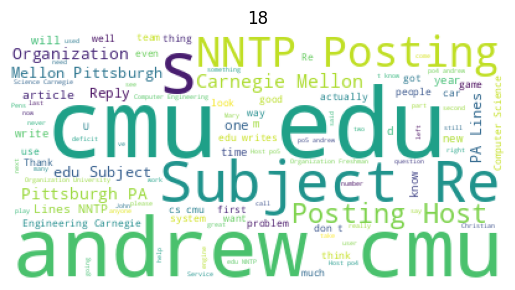

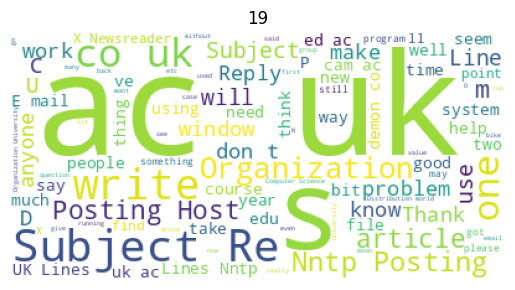

In [60]:
# compute word cloud on the document (raw text or frequencies)
word_cloud_from_classes(Y_pred)

In [62]:
# Compute cluster "purity":
purity = 0
for y in np.unique(Y_pred):
    idx = np.where(Y_pred == y)[0]
    res = Y[idx]
    uy, cy = np.unique(res, return_counts=True)
    purity += np.max(cy)
purity /= len(Y_pred)
purity

0.3102351069471451

In [63]:
def compute_purity(labels_true, labels_pred):
    unique_classes = np.unique(labels_true)
    purity = 0.0

    for true_class in unique_classes:
        indices = np.where(labels_true == true_class)[0]
        predicted_classes = labels_pred[indices]
        unique_predicted_classes, predicted_class_counts = np.unique(predicted_classes, return_counts=True)
        purity += np.max(predicted_class_counts)

    purity /= len(labels_true)

    return purity

compute_purity(Y, Y_pred)

0.3785575393318013

In [64]:
# Compute Rand Score and Adjusted Rand Score
from sklearn.metrics import rand_score
rand_score(Y_pred, Y)

0.8852879124091465

In [66]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(Y_pred, Y)

0.11120721708814237

# 2) Latent Semantic Analysis (LSA <=> SVD)


**Remember the LSA factorziation**:
$$
\begin{matrix}
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow
&
\begin{pmatrix}
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix}
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix}
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix}
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix}
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


In [67]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=50)
U = lsa.fit_transform(vectors)

tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=2)
tsne_mat = tsne.fit_transform(U)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.001s...
[t-SNE] Computed neighbors for 11314 samples in 0.794s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.115936
[t-SNE] Computed cond

<ipython-input-68-b03321a5cce6>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv', 20)
<ipython-input-68-b03321a5cce6>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 20)


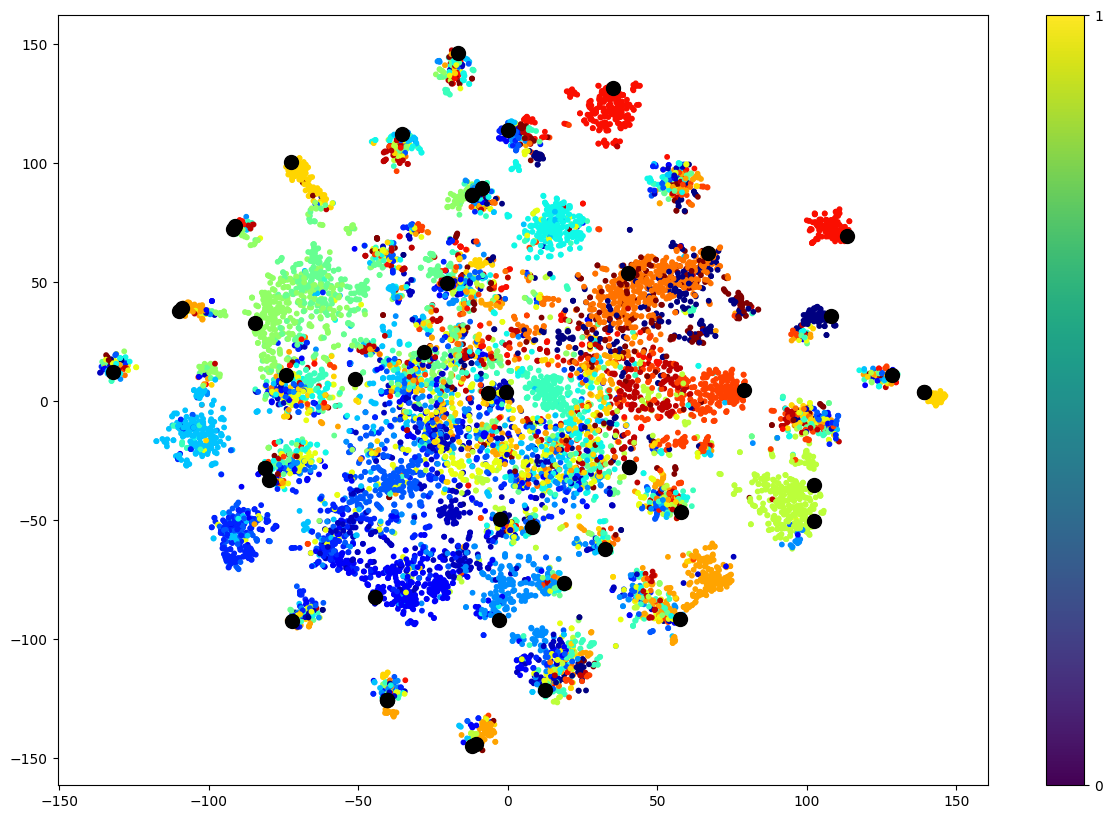

In [68]:
NN2cluster = np.argmax(np.abs(U), axis=0)
import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20)
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [69]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(11314, 1000)
48.02527841612162


## LDA-viz

In [76]:
!pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
# pip install install pyldavis
from __future__ import print_function
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(vectors)

pyLDAvis.sklearn.prepare(lda,vectors,vectorizer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'pyLDAvis.sklearn'

# Performances evaluation


**Compare the different approaches wrt three quantitative metrics.**

## LSA

In [82]:
kmeans_lsa = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(U)
kmeans_lsa.cluster_centers_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[ 2.17998061e-01,  1.45811573e-02,  7.32182540e-02,
         4.68988592e-02, -8.45290011e-02,  1.17508456e-02,
         2.45001682e-02, -1.33853149e-03, -4.38190855e-02,
         7.29460196e-03,  4.74046032e-02, -4.08002927e-02,
        -1.31330276e-01,  2.71230335e-02,  1.06647504e-01,
        -4.25570445e-02,  2.02205433e-01, -8.13838829e-02,
        -9.63900976e-02, -1.02299541e-01, -2.75724873e-02,
        -4.47585549e-02, -1.63835792e-01,  1.12828219e-01,
        -7.56819359e-02, -2.40713447e-02,  9.65372774e-02,
         9.35096887e-02, -1.02801246e-01, -1.37215842e-02,
         1.59652857e-02,  2.31070824e-02, -7.19549118e-03,
        -5.73470616e-03, -4.49184849e-02,  2.61979998e-02,
        -1.17295055e-02, -2.29422766e-02,  3.03588504e-02,
        -1.73937425e-02, -4.40065699e-02,  1.46668817e-02,
         1.00214851e-02, -1.99603136e-02, -4.19205027e-02,
         3.80873456e-03,  1.99074166e-02,  2.45336676e-02,
        -8.51075705e-03,  2.90850660e-02],
       [ 2.05

In [83]:
kmeans_lsa.cluster_centers_.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(20, 50)

In [84]:
Y_pred = kmeans_lsa.predict(U)
print(Y_pred[:10])
print(np.unique(Y_pred))

[ 5  5 15  3  3 10  5 15 15 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
compute_purity(Y, Y_pred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.3984444051617465

In [88]:
rand_score(Y_pred, Y)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.8696063500215578

In [89]:
adjusted_rand_score(Y_pred, Y)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.09991721780515747